<img align="right" src="https://github.com/cvs-health/coldstart/blob/main/examples/coldstart.png?raw=true">

# Quickstart
___

#### Overview:

Coldstart is a package for automatic data collection and feature engineering that should be used by new and seasoned data scientists/engineers interested in accelerating model development.

Data collection and feature engineering are among the most tedious and time-consuming steps in the data science workflow. Coldstart aims to solve this problem by encapsulating efficient patterns and abstracting away low-level details associated with dynamic query templating, query optimization, concurrent execution, memory management, data leakage, and pipeline deployment. The general order of events looks like this:

<img align="center" src="https://github.com/cvs-health/coldstart/blob/main/examples/coldstart_flow.png?raw=true">

Coldstart is meant to be a "Goldilocks" solution that sits somewhere between a collection of version-controlled queries and a full-fledged feature store. If you're making batch predictions that do not require ultra-low latency guarantees or if you're not taking full advantage of the warehouse’s available computing resources (i.e., waiting for queries dozens of queries to run one-by-one), then this package might be perfect for you!

TODO|Description
---|---
[Install](#Install)|Install coldstart
[Prep](#Prep)|Prep environment
[Inspect](#Inspect)|Inspect query bank
[Define](#Define)|Define left-most table
[Start](#Start)|Start `FeatureFactory`
[Run](#Run)|Run `FeatureFactory`
[Get](#Get)|Get dataframe or table
[Model](#Model)|Pass to model

### Install

First, let's install coldstart with pip.

___

In [1]:
! pip install coldstart --user

### Prep

Now, let's prepare our notebook environment with some conventional imports and options.

___

In [2]:
# automatically restart kernel after installs
import os
if not os.getenv("IS_TESTING"):
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

# format notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.4f}'.format

# get project ID from gcloud
TIMESTAMP = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
PROJECT_ID = ''
if not os.getenv('IS_TESTING'):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print(f'Start Time: {TIMESTAMP}')
    print(f'Project ID: {PROJECT_ID}')

Start Time: 2022-11-09 04:10:02
Project ID: anbc-dev


### Inspect

We are ready to begin inspecting the query bank in coldstart!

The default query directory (with some test queries included for demonstrative purposes) is located in the coldstart package directory (`coldstart/queries`). If you're working from a locally/internally maintained fork that you clone for collaborative purposes, you may choose to collect your queries here. You can also specify an alternative `query_dir` by passing this argument to any of the following methods shown below. So, you can tightly or loosely couple the query bank; it's up to you.

These convenience methods allow you to see what's available in the query bank for subsequent use:

- `FeatureFactory.list_dialects`
- `FeatureFactory.list_entities`
- `FeatureFactory.list_domains`
- `FeatureFactory.list_queries`

It's a good idea to begin with listing available dialects (e.g., bigquery). This will let you know which databases/warehouses have associated queries in the query bank.

Then you'll want to list available entities. Entities, in this sense, are things that you're interested in modeling. Some examples might include individual_id, proxy_id, group_id, cohort_id, etc. Think about them as row-level observation identifiers that will go into your model for training or prediction. Keep in mind that entities are not necessarily the same as primary keys because you may have multiple rows with the same entity_id for different time periods (don't worry, coldstart handles this for you by creating a composite key so long as the patterns detailed below are being observed).

From here, you can list available domains. Domains are roughly analagous to groups of similar queries. For example, the entity [NCAA] team_id might have domains like: mascot, venue, games, etc. This is where the power starts kicking in because as long as the domains are fairly self-explanatory, users can understand thematically understand what types of features the underlying queries will be returning. This is a big win for indviduals that are less familiar with each and every query and simply want to begin modeling with some peer-reviewed features.

Lastly, you can optionally list available domains. This is similar to listing domains but one level down. Typically, you'd only want to do this if you're already familiar with the features being returned by specific queries of interest and you're looking to explicitly avoid other queries or features in the same domain.

___

In [2]:
from coldstart import FeatureFactory

# instantiate feature_factory
ff = FeatureFactory()

# list available dialects
dialects = ff.list_dialects()
print(f'Available dialects: {dialects}')

Available dialects: ['bigquery']


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# list available entities
entities = ff.list_entities(dialect='bigquery')
print(f'Available entities: {entities}')

Available entities: ['team_id', 'game_id']


In [4]:
# list available domains
domains = ff.list_domains(dialect='bigquery', entity_id='team_id')
print(f'Available domains: {domains}')

Available domains: ['mascot', 'wins', 'losses', 'venue', 'taxonomy']


In [5]:
# list available queries
queries = ff.list_queries(dialect='bigquery', entity_id='team_id')
print(f'Available queries: {queries}')

Available queries: ['testQuery3', 'testQuery1', 'testQuery2', 'testQuery5', 'testQuery4']


#### IMPORTANT

Queries in the query bank must adhere to an established pattern. It's this pattern that makes consistent dynamic runtime templating possible. All queries must:

- Have a unique file name
    > **Tip**: By beginning the file name with the corresponding entity and domain name, you will easily be able to estasblish feature lineage back to the query because the final table appends the query name to the column name to ensure uniqueness 
- Be tagged with `DIALECT`, `ENTITY`, and `DOMAIN`
- Use the default `idx` column (which is a concatonation of `entity_id` + `min_date` + `max_date`) in the **SELECT** in all CTEs/subqueries and the outer-most query
    > **Tip**: You do not need to carry the `entity_id`, `min_date`, or `max_date` down through CTEs/subqueries because it is baked into `idx`
- Use the `{LEFTMOST_TABLE}` variable as the left-most table in the **FROM**
- Use `min_date` and `max_date` to constrain relevant date columns in the **WHERE** if dates are involved
- Have an outer-most query that uses `idx` in the **GROUP BY** if aggregation is involved

A typical query (e.g., `teamGameStats.sql`) will look something like this:

```sql
-- DIALECT: your_dialect (e.g., bigquery)
-- ENTITY: your_entity_id (e.g., team_id)
-- DOMAIN: your_domain (e.g., game)
WITH T1 AS (
    SELECT
        LMT.idx,
        A.some_column,
        B.some_other_column,
        ...
    FROM
        {LEFTMOST_TABLE} AS LMT
        INNER JOIN some_schema.some_table_1 AS A
            ON LMT.team_id = A.team_id
        LEFT JOIN some_schema.some_table_2 AS B
            ON A.id = B.team_id
        ...
    WHERE
        some_date_column >= LMT.min_date
        AND some_date_column <= LMT.max_date
        ...
)
SELECT
    T1.idx,
    SUM(T1.some_column) AS some_sum,
    SUM(T1.some_other_column) AS some_other_sum,
    ...
FROM
    T1
GROUP BY
    T1.idx
```

### Define

Now it's time to define and create your left-most table. This table will be used to constrain all of the associated feature queries. Coldstart can save *a lot* of time collecting data and engineering features, but it cannot define your modeling problem for you.

This table must have at least 2 columns: `entity_id` and `y` where entity_id corresponds with tagged queries (discussed above) in the query bank and y corresponds with the dependent variable that you're eventually modeling. Optionally, you can also include a `min_date` and a `max_date` column so that each row is parameterized accordingly (if you do not include dates in your table, the `date_range` argument will be used for all records). A typical `leftmost_table` will look like this:

entity_id|y
---|---
abc|0
def|1
...|...

Or:

entity_id|y|min_date|max_date
---|---|---|---
abc|0|2020-01-01|2020-12-31
abc|1|2021-01-01|2021-12-31
def|0|2020-01-01|2020-12-31
def|1|2021-01-01|2021-12-31
...|...|...|...

___

In [6]:
from sqlalchemy import create_engine

# write query
sql = """
CREATE OR REPLACE TABLE anbc-dev.dso_ent_dev.coldstart_test_leftmost_tmp
AS
WITH T1 AS (
    SELECT
        T.id AS team_id,
        G.season,
        CASE
            WHEN G.win = True Then 1
            ELSE 0
        END AS win_count,
        CASE
            WHEN G.win = False Then 1
            ELSE 0
        END AS loss_count
    FROM
        bigquery-public-data.ncaa_basketball.mbb_teams AS T
        LEFT JOIN bigquery-public-data.ncaa_basketball.mbb_historical_teams_games AS G
            ON T.id = G.team_id
    WHERE
        season >= EXTRACT(YEAR FROM DATE('2016-01-01'))
        AND season <= EXTRACT(YEAR FROM DATE('2016-01-01'))
)
SELECT
    T1.team_id,
    CASE
        WHEN SUM(T1.win_count) / (SUM(T1.win_count) + SUM(T1.loss_count)) > 0.5
        THEN 1
        ELSE 0
    END AS y
FROM
    T1
GROUP BY
    T1.team_id
ORDER BY
    y DESC
"""

# create engine
engine = create_engine("bigquery:///?ProjectId='anbc-dev'")

# execute query
with engine.connect() as connection:
    result = connection.execute(sql)

# view dataframe
leftmost_df = pd.DataFrame(result.fetchall(), columns=result._metadata.keys)
print(leftmost_df.shape)
leftmost_df.head()

(351, 2)


,team_id,y
0,fe406882-9f22-495e-9df6-ef357a6803c6,1
1,ca478771-aa3d-4231-81e0-b70f519134fb,1
2,5c7bf63f-bc39-43c5-9907-73b50b7a6b34,1
3,8ab00d43-840a-4c96-bdee-bf88fa6e3f11,1
4,f8c705b7-87d3-411a-9c8b-5124daab0469,1


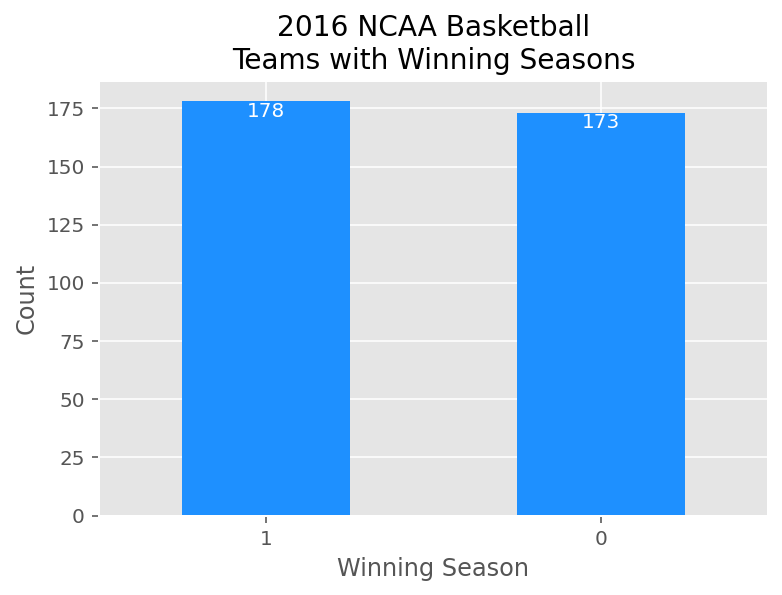

In [7]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            if _y > 1:
                ax.text(_x, _y, value, ha='center', va='top', color='w')
            else:
                ax.text(_x, _y, value, ha='center')
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# plot
temp = leftmost_df['y'].value_counts()
with plt.style.context('ggplot'):
    ax = temp.plot.bar(rot=0, legend=False, color='dodgerblue')
    ax.set_title('2016 NCAA Basketball\nTeams with Winning Seasons', size=14)
    ax.set_xlabel('Winning Season', size=12)
    ax.set_ylabel('Count', size=12)
    show_values_on_bars(ax)
    plt.show()

### Start

Now we can start our engine! To do this, create a dictionary with the dialect of interest (based on the results of listing dialects covered above) and the schema/dataset that you will be working in. Different dialects may require additional key/value pairs, but since the `db_spec` is extensible this should not be a problem. SQLAlchemy is used behind the scenes so the keys/values should be the same as what you'd need to create an engine that way.

___

In [8]:
# set database spec
db_spec = {
    'dialect': 'bigquery',
    'project_id': PROJECT_ID,
    'schema': 'dso_ent_dev' # aka dataset
}

# start engine
ff.start_engine(db_spec)

### Run

We've arrived at the fun part! `FeatureFactory` is a powerful class that abstracts away the templating, cuncurrent execution, joining, and cleanup of all the underlying feature queries. The main arguments are `leftmost_table`, `feature_table` (for specifying where the results should write to), `entity_id`, `domains` (for listing one, many, or all applicable domains of interest), and `date_range` (for specifying a min and max date to constrain underlying queries in the event that the leftmost_table does not already contain them).

The are several keyword arguments that you can specify to further modify behavior such as but not limited to: stopping on a single query error, returning an out-of-core dataframe, automatically downcasting data types when possible, and splitting queries into mini batches. For a full list of supported arguments, refer to the docstring below.

___

In [9]:
help(FeatureFactory)

Help on class FeatureFactory in module coldstart.build:

class FeatureFactory(builtins.object)
 |  Coldstart's main class
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_dataframe(self)
 |      For returning a dataframe object
 |      
 |      Returns:
 |          DataFrame: Training data
 |  
 |  get_table(self)
 |      For returning final feature table name
 |      
 |      Returns:
 |          str: Table name containing training data
 |  
 |  run(self, leftmost_table=None, feature_table=None, entity_id=None, domains=None, queries=None, date_range=None, query_dir=None, export_dir=None, drop_intermedieate_tables=True, return_df=True, compute_df=True, stop_on_error=False, downcast=False, batching=False, batch_size=None)
 |      Used for running FeatureFactory
 |      
 |      Args:
 |          leftmost_table (str): Left-most table used for constraining feature
 |              queries. Should incl

In [10]:
# set tables
LEFTMOST_TABLE = 'anbc-dev.dso_ent_dev.coldstart_test_leftmost_tmp'
FEATURE_TABLE = 'anbc-dev.dso_ent_dev.coldstart_test_features_tmp'

# run feature factory
ff.run(
    leftmost_table=LEFTMOST_TABLE,
    feature_table=FEATURE_TABLE,
    entity_id='team_id',
    domains=domains,
    queries=None, # test this
    date_range=['2010-01-01', '2015-01-01'],
    query_dir=None, # test this
    export_dir=None, # test this
    return_df=True,
    compute_df=True,
    stop_on_error=False,
    downcast=False, # test this
    batching=False,
    batch_size=None,
)

# stop engine
ff.stop_engine()

Overall Progress:  30%|███       | 30/100 [00:03<00:13,  5.11it/s]STAGING: Complete
PARSING: Complete
TEMPLATING: Complete



Query Progress: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Overall Progress:  70%|███████   | 70/100 [00:07<00:03,  8.42it/s]

QUERYING: Complete
      query_name query_status  query_seconds
0     testQuery3      SUCCESS              3
1     testQuery1      SUCCESS              3
2     testQuery2      SUCCESS              3
3     testQuery5      SUCCESS              3
4     testQuery4      SUCCESS              2
5  leftMostTable      SUCCESS              3
Overall Progress:  90%|█████████ | 90/100 [00:12<00:01,  6.02it/s]MERGING: Complete



Query Progress: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

Overall Progress: 100%|██████████| 100/100 [00:12<00:00,  7.03it/s]


### Get

Our results are ready! You can return a dataframe object or the name of the `feature_table` specified earlier.

___

In [11]:
# return dataframe
features_df = ff.get_dataframe().set_index('idx', drop=True)

# view dataframe
print(features_df.shape)
features_df.sample(5)

(351, 20)


,y,testQuery5_venue_state,testQuery5_venue_city,testQuery5_venue_capacity,testQuery2_loss_count,testQuery3_mascot_common_name,testQuery3_tax_subspecies,testQuery3_tax_species,testQuery3_tax_genus,testQuery3_tax_family,testQuery3_tax_order,testQuery3_tax_class,testQuery3_tax_phylum,testQuery3_tax_kingdom,testQuery3_tax_domain,testQuery3_non_tax_type,testQuery1_win_count,testQuery4_league,testQuery4_conference,testQuery4_division
idx,,,,,,,,,,,,,,,,,,,,
61a3908a-7492-4b6f-809e-12c61976bb0a_2010-01-01_2015-01-01,1,IL,Chicago,4486,106,Wolf,None,lupus,Canis,Canidae,Carnivora,Mammalia,Chordata,Animalia,Eukaryota,None,87,NCAAM,MVC,D1
53aaac6a-796e-41a6-a04e-6ce74c5717f8_2010-01-01_2015-01-01,0,NC,Greensboro,5700,122,Domestic dog,familiaris,lupus,Canis,Canidae,Carnivora,Mammalia,Chordata,Animalia,Eukaryota,None,73,NCAAM,MEAC,D1
0f63a6f5-bda7-4fd9-9271-8d33f555ca19_2010-01-01_2015-01-01,1,GA,Atlanta,8600,104,Yellow Jacket,None,None,Vespula,Vespidae,Hymenoptera,Insecta,Arthropoda,Animalia,Eukaryota,None,89,NCAAM,ACC,D1
2f513e67-f019-4eec-9096-fbc5911858b6_2010-01-01_2015-01-01,0,DC,Washington,4500,89,Eagle,None,None,None,Accipitridae,Accipitriformes,Aves,Chordata,Animalia,Eukaryota,None,101,NCAAM,PATRIOT,D1
9b66e1e0-aace-4671-9be2-54c8acf5ecfc_2010-01-01_2015-01-01,1,VA,Richmond,7201,83,Spider,None,None,None,None,Araneae,Arachnida,Arthropoda,Animalia,Eukaryota,None,120,NCAAM,A10,D1


In [12]:
# return table
features_table = ff.get_table()
print(f'Table name: {features_table}')

Table name: anbc-dev.dso_ent_dev.coldstart_test_features_tmp


In [13]:
# confirm that table exists
sql = f"""
SELECT *
FROM {FEATURE_TABLE}
"""

# create engine
engine = create_engine("bigquery:///?ProjectId='anbc-dev'")

# execute query
with engine.connect() as connection:
    result = connection.execute(sql)

# view dataframe
check_df = pd.DataFrame(result.fetchall(), columns=result._metadata.keys)
print(check_df.shape)
check_df.head()

(351, 21)


,idx,y,testQuery5_venue_state,testQuery5_venue_city,testQuery5_venue_capacity,testQuery2_loss_count,testQuery3_mascot_common_name,testQuery3_tax_subspecies,testQuery3_tax_species,testQuery3_tax_genus,testQuery3_tax_family,testQuery3_tax_order,testQuery3_tax_class,testQuery3_tax_phylum,testQuery3_tax_kingdom,testQuery3_tax_domain,testQuery3_non_tax_type,testQuery1_win_count,testQuery4_league,testQuery4_conference,testQuery4_division
0,71874e7e-8260-43f9-bb7c-65f267dbe8ce_2010-01-0...,0,LA,Natchitoches,3900,86,None,None,None,None,None,None,None,None,None,None,Devils,101,NCAAM,SOUTHLAND,D1
1,ef184799-d79b-49d9-a662-991eaf4044cd_2010-01-0...,1,TX,College Station,12989,79,None,None,None,None,None,None,None,None,None,None,Weather,123,NCAAM,SEC,D1
2,7a270923-01d6-4a6f-a93e-e8786266d502_2010-01-0...,0,NY,Bronx,2345,96,None,None,None,None,None,None,None,None,None,None,None,98,NCAAM,MAAC,D1
3,0113eea0-c943-4fff-9780-ae0fb099e7ef_2010-01-0...,1,NY,Buffalo,2176,101,None,None,None,None,None,None,None,None,None,None,Griffins,93,NCAAM,MAAC,D1
4,5873529e-e5e3-4a06-8a03-fa4cbe509880_2010-01-0...,0,MS,Itta Bena,5000,131,None,None,None,None,None,None,None,None,None,None,Devils,60,NCAAM,SWAC,D1


### Model

That's it! Now you're ready to model to your heart's content :)

___

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.calibration import calibration_curve

# construct pipeline
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, copy=False)),
        ('scaler', StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='NA', copy=False)),
        ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=pd.CategoricalDtype)),
    ]
)
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', RandomForestClassifier()),
    ]
)

# set features and class label
X = features_df.iloc[:, 1:]
y = features_df.iloc[:, 0]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# fit pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(copy=False,
                                                                                 fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2558ca8b90>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(copy=False,
           

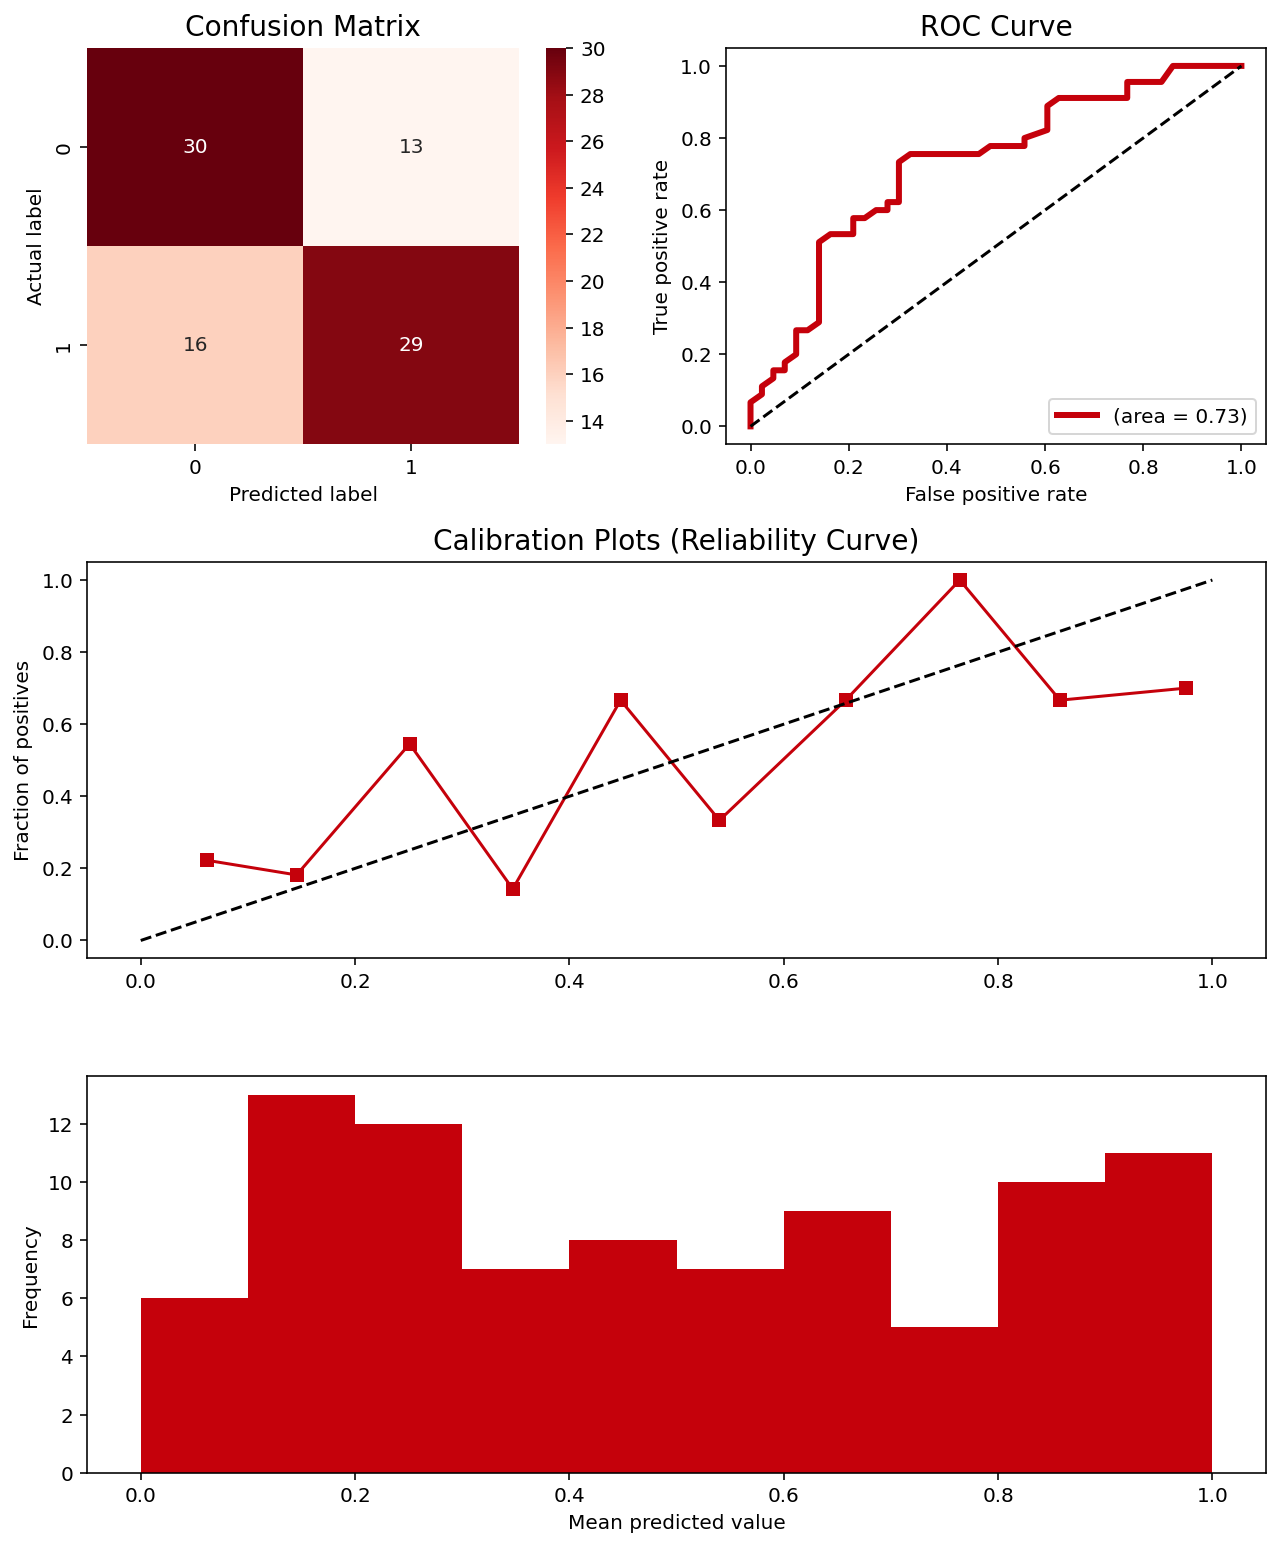

In [15]:
def clf_eval_viz(y_test, y_pred, y_proba, large=True): 
    
    # create subplot
    if large == True:
        plt.figure(figsize=(9, 14))
    else:
        plt.figure(figsize=(6, 9))
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=2)
    ax2 = plt.subplot2grid((4,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((4,4), (1, 0), colspan=4)
    ax4 = plt.subplot2grid((4,4), (2, 0), colspan=4)
    
    # confusion matrix
    ax1.set_title('Confusion Matrix', fontsize=14)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='', cmap='Reds', ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Actual label')
    
    # roc curve
    ax2.set_title('ROC Curve', fontsize=14)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    area = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label='(area = %0.2f)' % area, linewidth=3, color='#c5010b')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend(loc='lower right')
    
    # calculate fraction of positives and mean predicted value
    fop, mpv = calibration_curve(y_test, y_proba, n_bins=10)
    
    # calibration plot
    ax3.plot(mpv, fop, 's-', color='#c5010b')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_ylabel('Fraction of positives')
    ax3.set_ylim([-0.05, 1.05])
    ax3.set_title('Calibration Plots (Reliability Curve)', fontsize=14)

    # mean probability by decile plot
    ax4.hist(y_proba, range=(0, 1), bins=10, histtype='stepfilled', lw=2, color='#c5010b')
    ax4.set_xlabel('Mean predicted value')
    ax4.set_ylabel('Frequency')
    
    # tight layout
    plt.tight_layout()
    plt.show()


# evaluate model
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype('int')
clf_eval_viz(y_test, y_pred, y_proba, large=True)

### Wrap

Hopefully this demo communicates how quick, efficient, and painless modeling can be with some incremental up front investment in curating queries with coldstart.

By now it should be evident that I like puns... Coldstart helps overcome coldstart modeling problems for data scientists!

P.S. The model wasn't supposed to be a good model and it is not a reflection on the author's modeling capabilities or NCAA basketball knowledge. The dataset was, however, useful for demonstrative purposes.

___